In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import keras_tuner as kt
from sklearn.model_selection import train_test_split

In [4]:
data = np.load('/content/drive/MyDrive/140111/data.npy')

In [5]:
types = open('/content/drive/MyDrive/140111/types.txt').readlines()

In [6]:
sub_types = open('/content/drive/MyDrive/140111/subtypes.txt').readlines()

In [7]:
df = pd.DataFrame(columns=['id','type','subtype','type_code', 'subtype_code'])
df.id = np.arange(data.shape[0])
df.type = types
df.type = df.type.str.strip()
df.subtype = sub_types
df.subtype = df.subtype.str.strip()
df = df.drop(df[df.type=='NA'].index)
df = df.drop(df[df.subtype=='NA'].index)
df.type_code = LabelEncoder().fit_transform(df.type)
df.subtype_code = LabelEncoder().fit_transform(df.subtype)

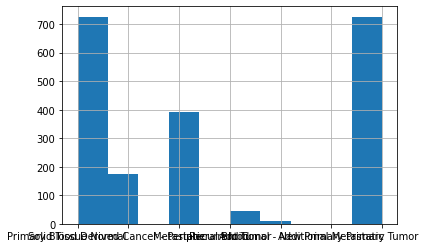

In [8]:
primary_df = df[df.subtype=='Primary Tumor']
primary_df = primary_df.sample(n=726)
df = df.drop(df[df.subtype=='Primary Tumor'].index)
df = pd.concat([df,primary_df],axis=0)
df.subtype.hist()

In [9]:
for c in df.subtype.unique():
  print(c,len(df[df.subtype==c]))

Solid Tissue Normal 726
Primary Blood Derived Cancer - Peripheral Blood 173
Metastatic 392
Recurrent Tumor 45
Additional - New Primary 11
Additional Metastatic 1
Primary Tumor 726


In [10]:
cat_codes = to_categorical(df.subtype_code.values)
X_train, X_test, y_train, y_test  = train_test_split(df.id.values , cat_codes, test_size=0.25)

In [11]:
X_train = data[X_train]
X_test = data[X_test]       

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
model = Sequential()

model.add(Conv2D(32 , kernel_size=15 , strides=2 , padding="same" , input_shape=(128,128,1)))
model.add(LeakyReLU(alpha=0.2))

          
model.add(Conv2D(256 , kernel_size=15 , strides=2 , padding="same" ))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.5))

model.add(Conv2D(512 , kernel_size=15 , strides=2 , padding="same" ))
model.add(LeakyReLU(alpha=0.2))

          
model.add(Conv2D(768 , kernel_size=15 , strides=2 , padding="same" ))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.2))

# softmax classifier
model.add(Dense(cat_codes.shape[1]))
model.add(Activation("softmax"))

In [15]:
opt = Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy",f1_m] )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        7232      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1843456   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 512)       29491712  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 512)       0

In [16]:
hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[stop_early])

Epoch 1/100
49/49 [==============================] - 52s 818ms/step - loss: 2.7991 - accuracy: 0.3968 - f1_m: 0.2846 - val_loss: 0.8366 - val_accuracy: 0.8536 - val_f1_m: 0.6544
Epoch 2/100
49/49 [==============================] - 33s 674ms/step - loss: 0.5891 - accuracy: 0.8270 - f1_m: 0.8003 - val_loss: 0.3758 - val_accuracy: 0.9210 - val_f1_m: 0.9093
Epoch 3/100
49/49 [==============================] - 33s 681ms/step - loss: 0.3636 - accuracy: 0.9016 - f1_m: 0.9011 - val_loss: 0.3237 - val_accuracy: 0.9249 - val_f1_m: 0.9104
Epoch 4/100
49/49 [==============================] - 33s 666ms/step - loss: 0.2967 - accuracy: 0.9203 - f1_m: 0.9180 - val_loss: 0.3619 - val_accuracy: 0.8613 - val_f1_m: 0.8499
Epoch 5/100
49/49 [==============================] - 33s 675ms/step - loss: 0.2563 - accuracy: 0.9293 - f1_m: 0.9282 - val_loss: 0.2732 - val_accuracy: 0.9075 - val_f1_m: 0.9023
Epoch 6/100
49/49 [==============================] - 33s 674ms/step - loss: 0.2494 - accuracy: 0.9228 - f1_m: 

In [17]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 2s 132ms/step - loss: 0.2237 - accuracy: 0.9345 - f1_m: 0.9270


[0.22367480397224426, 0.9344894289970398, 0.926981508731842]

In [18]:
import matplotlib.pyplot as plt

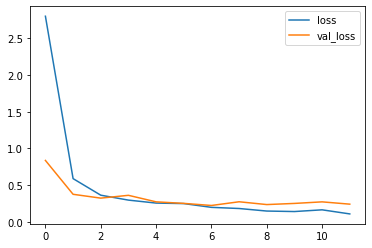

In [19]:
plt.plot(hist.epoch , hist.history['loss'])
plt.plot(hist.epoch , hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

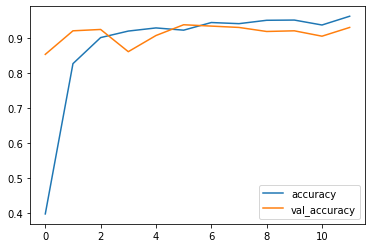

In [20]:
plt.plot(hist.epoch , hist.history['accuracy'])
plt.plot(hist.epoch , hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [21]:
# model.save('classifier.h5')